In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from nibabel import freesurfer as fs
import neuromaps
from neuromaps.datasets import fetch_annotation
from neuromaps import transforms

%load_ext rpy2.ipython

In [2]:
%%R 

suppressPackageStartupMessages({
    library(cowplot)
    library(ggnewscale)
    library(ggsegGlasser)
    library(ggseg)
    library(hexbin)
    library(see)
    library(tidyverse)
    theme_set(theme_cowplot())
})

options(dplyr.width = Inf)

In addition: Warning message:
package ‘ggnewscale’ was built under R version 4.3.3 


## Load Glasser parcellation for right hemisphere

In [3]:
# Read in Glasser 180 right hemisphere
glasser180_right_file = "/Users/abry4213/data/neuroimaging_atlases/surfaces/Glasser_2016/fsaverage/rh.HCP-MMP1.annot"
glasser180_right_vertices, glasser180_right_ctab, glasser180_right_names = fs.read_annot(glasser180_right_file)

glasser180_right_vertices = glasser180_right_vertices.byteswap().newbyteorder()
glasser180_right_ctab = glasser180_right_ctab.byteswap().newbyteorder()
glasser180_right_names = [name.decode() for name in glasser180_right_names]

# Create Glasser 180 right hemi lookup table
glasser180_right_LUT = pd.DataFrame({'index': np.arange(0, len(glasser180_right_names)), 'Glasser_RH_ROI': glasser180_right_names})

# Convert glasser array to dataframe
glasser180_right_df = pd.DataFrame({'index': glasser180_right_vertices, 'vertex_number': np.arange(0, len(glasser180_right_vertices))})
glasser180_right_df['Glasser_RH_ROI'] = glasser180_right_df['index'].map(glasser180_right_LUT.set_index('index')['Glasser_RH_ROI'])

# Drop index
glasser180_right_df = glasser180_right_df.drop(columns=['index'])

## Load overlapping community detection algorithm (OCDA) modules

In [4]:
# Read in OCDA modules
ocda_modules_glasser180_right = pd.read_csv("/Users/abry4213/github/OverlappingCommunityDetection_HCP/Results/table_of_modules_AF_renamed.csv")
ocda_modules_glasser180_right.columns = ["Glasser_RH_ROI", "module", "overlapping"]

# Load module orders
module_orders = pd.read_csv("module_order.csv")

In [5]:
%%R -i ocda_modules_glasser180_right,module_orders -o ocda_modules_glasser180_right

# Tidy data
ocda_modules_glasser180_right <- ocda_modules_glasser180_right %>% 
  mutate(module = factor(module, levels = module_orders$Module))%>% 
  filter(module != "Unassigned")

## Load Yeo 2011 7-network parcellation

In [6]:
yeo7_right_file = "/Users/abry4213/data/neuroimaging_atlases/surfaces/Yeo_JNeurophysiol11_FreeSurfer/fsaverage/label/rh.Yeo2011_7Networks_N1000.annot"
yeo7_right_vertices, yeo7_right_ctab, yeo7_right_names = fs.read_annot(yeo7_right_file)

yeo7_right_vertices = yeo7_right_vertices.byteswap().newbyteorder()
yeo7_right_ctab = yeo7_right_ctab.byteswap().newbyteorder()
yeo7_right_names = [name.decode() for name in yeo7_right_names]

# Create Yeo 7 right hemi lookup table
yeo7_right_LUT = pd.read_csv("yeo7_lookup.csv")

# Convert yeo17 array to dataframe
yeo7_right_df = pd.DataFrame({'index': yeo7_right_vertices, 'vertex_number': np.arange(0, len(yeo7_right_vertices))})
yeo7_right_df['Yeo7_RH_ROI'] = yeo7_right_df['index'].map(yeo7_right_LUT.set_index('index')['Yeo7_RH_ROI'])

# Drop index
yeo7_right_df = yeo7_right_df.drop(columns=['index'])

## Load Margulies 2016 principal gradient vertices

In [7]:
# Add connectome workbench to path
os.environ['PATH'] = os.environ['PATH'] + ':/Applications/workbench/bin_macosx64'

# Download Margulies principal gradient for right hemisphere
margulies_principal_gradient = fetch_annotation(source='margulies2016', desc='fcgradient01')
margulies_principal_gradient_fsaverage_right = transforms.fslr_to_fsaverage(margulies_principal_gradient, '164k', 'R')[0]
margulies_principal_gradient_fsaverage_right_vertices = margulies_principal_gradient_fsaverage_right.agg_data()

margulies_principal_gradient_fsaverage_right_df = pd.DataFrame({'PC1_value': margulies_principal_gradient_fsaverage_right_vertices, 
                                                                'vertex_number': np.arange(0, len(margulies_principal_gradient_fsaverage_right_vertices))})

## Merge all the data!

In [8]:
# Create a merged df
merged_df = glasser180_right_df

# Merge with OCDA modules
merged_df = pd.merge(merged_df, ocda_modules_glasser180_right, on='Glasser_RH_ROI', how='left')

# Merge with Yeo 7 networks
merged_df = pd.merge(merged_df, yeo7_right_df, on='vertex_number', how='left')

# Merge with margulies principal gradient
merged_df = pd.merge(merged_df, margulies_principal_gradient_fsaverage_right_df, on='vertex_number', how='left')

# Drop rows where Glasser_RH_ROI is '???'
merged_df = merged_df.query('Glasser_RH_ROI != "???" and Yeo7_RH_ROI != "???"')

## How do the overlapping regions compare with the Yeo 2011 17-network functional atlas?

`summarise()` has grouped output by 'module', 'overlapping', 'Glasser_RH_ROI',
'Yeo7_RH_ROI'. You can override using the `.groups` argument.
Joining with `by = join_by(module, Glasser_RH_ROI)`


In addition: Warning message:
Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


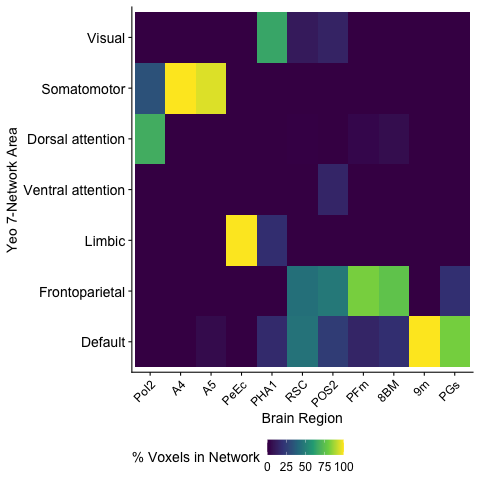

In [9]:
%%R -i merged_df,ocda_modules_glasser180_right

merged_df %>% 
    dplyr::select(-vertex_number) %>%
    filter(overlapping=="Overlapping") %>%
    mutate(Yeo7_RH_ROI = ifelse(is.na(Yeo7_RH_ROI), "None", Yeo7_RH_ROI)) %>%
    filter(Yeo7_RH_ROI != "None") %>%
    group_by(module, Glasser_RH_ROI) %>% 
    mutate(num_voxels = n()) %>% 
    group_by(module, overlapping, Glasser_RH_ROI, Yeo7_RH_ROI) %>% 
    summarise(num_voxels_in_yeo7 = n(),
              prop_voxels_in_yeo7 = 100*num_voxels_in_yeo7/num_voxels) %>% 
    ungroup() %>%
    distinct() %>%
    complete(module, Glasser_RH_ROI, Yeo7_RH_ROI, fill=list(prop_voxels_in_yeo7=0)) %>% 
    semi_join(., ocda_modules_glasser180_right %>% dplyr::select(Glasser_RH_ROI, module)) %>%
    ungroup() %>% 
    mutate(Yeo7_RH_ROI = factor(Yeo7_RH_ROI, levels=rev(c("Visual", "Somatomotor", "Dorsal attention", "Ventral attention", "Limbic", "Frontoparietal", "Default"))),
           ROI_label_short = gsub("_ROI", "", gsub("R_", "", Glasser_RH_ROI))) %>%
    mutate(ROI_label_short = factor(ROI_label_short, levels = c("PoI2", "A4", "A5", "PeEc", "PHA1", "RSC", "POS2", "PFm", "8BM", "9m", "PGs"))) %>%
    ggplot(data=., mapping=aes(y=Yeo7_RH_ROI, x=ROI_label_short, fill=prop_voxels_in_yeo7)) +
    geom_tile(linewidth=0.5) +
    xlab("Brain Region") +
    ylab("Yeo 7-Network Area") +
    labs(fill="% Voxels in Network") +
    scale_fill_viridis_c() +
    theme(legend.position="bottom",
          strip.background = element_blank(),
          axis.text.y = element_text(size=14),
          axis.text.x = element_text(angle=45, hjust=1, size=12))
# ggsave("../Plots/Overlapping_regions_vs_Yeo_atlas.svg", width=5, height=4, dpi=300, units="in")

## How do overlapping vs. non-overlapping modules compare in the principal Margulies gradient?

### One violin plot comparing distribution of PC1 values in overlapping vs. non-overlapping regions

In [15]:
%%R -i merged_df 

merged_df %>%
    filter(module != "Unassigned") %>%
    mutate(overlapping=factor(overlapping, levels=c("Overlapping", "Non-overlapping"))) %>%
    ggplot(data=., mapping=aes(x=overlapping, y=PC1_value, fill=overlapping, color=overlapping)) +
    geom_violinhalf(scale="width", color="black", position = position_dodge(width = 1), width=0.95, alpha=0.85)  +
    geom_point(position = position_jitter(width = 0.1, height=0),
                            size = 1, alpha=0.1, stroke=0) +
    stat_summary(color="black", fun="mean", geom="crossbar", width=0.35, linewidth=0.35, 
            show.legend=FALSE, position = position_nudge(x=0.25)) +
    ylab("Principal Gradient value (a.u.)") +
    xlab("OSLOM Region Classification") +
    facet_grid(. ~ overlapping, space="free", scales="free_x", switch="both") +
    scale_fill_manual(values=c("Overlapping"="#9F3BC5",
                               "Non-overlapping"="#c1cdbf")) +  
    scale_color_manual(values=c("Overlapping"="#9F3BC5",
                               "Non-overlapping"="#c1cdbf")) + 
    theme(legend.position="none",
          strip.background = element_blank(),
          strip.text = element_blank())
ggsave("../Plots/OSLOM_Classification_vs_Margulies_PC1_vertexwise.svg", width=5, height=5.5, units="in", dpi=300)

### Compare the SD of PG1 values in overlapping vs. non-overlapping regions

In [20]:
%%R -i merged_df 

merged_df %>%
    filter(module != "Unassigned") %>%
    group_by(Glasser_RH_ROI, overlapping) %>% 
    summarise(PC1_SD = sd(PC1_value)) %>%
    ungroup() %>%
    mutate(overlapping=factor(overlapping, levels=c("Overlapping", "Non-overlapping"))) %>% 
    ggplot(data=., mapping=aes(x=overlapping, y=PC1_SD, fill=overlapping, color=overlapping)) +
    geom_violinhalf(scale="width", color="black", position = position_dodge(width = 1), width=0.95, alpha=0.85)  +
    geom_point(position = position_jitter(width = 0.05, height=0),
                            size = 2.5, alpha=0.6, stroke=0) +
    stat_summary(color="black", fun="mean", geom="crossbar", width=0.35, linewidth=0.35, 
            show.legend=FALSE, position = position_nudge(x=0.25)) +
    scale_fill_manual(values=c("Overlapping"="#9F3BC5",
                               "Non-overlapping"="#c1cdbf")) +  
    scale_color_manual(values=c("Overlapping"="#9F3BC5",
                               "Non-overlapping"="#c1cdbf")) + 
    ylab("Principal Gradient SD") +
    theme(legend.position="none",
          strip.background = element_blank(),
          strip.text = element_blank())
ggsave("../Plots/OSLOM_Classification_vs_Margulies_PC1_SD.svg", width=4, height=3.6, units="in", dpi=300)

`summarise()` has grouped output by 'Glasser_RH_ROI'. You can override using
the `.groups` argument.


## Plot the # vertices in overlapping vs. non-overlapping regions

In [24]:
%%R -i merged_df 

# Vertex-wise distributions
merged_df %>%
    filter(module != "Unassigned") %>%
    group_by(Glasser_RH_ROI, overlapping) %>%
    summarise(num_vertices = n()) %>%
    ungroup() %>%
    mutate(overlapping=factor(overlapping, levels=c("Overlapping", "Non-overlapping"))) %>%
    ggplot(data=., mapping=aes(x=overlapping, y=num_vertices, fill=overlapping, color=overlapping)) +
    geom_violinhalf(scale="width", color="black", position = position_dodge(width = 1), width=0.95, alpha=0.85)  +
    geom_point(position = position_jitter(width = 0.05, height=0),
                            size = 2.5, alpha=0.6, stroke=0) +
    stat_summary(color="black", fun="mean", geom="crossbar", width=0.35, linewidth=0.35,
            show.legend=FALSE, position = position_nudge(x=0.25)) +
    scale_fill_manual(values=c("Overlapping"="#9F3BC5",
                               "Non-overlapping"="#c1cdbf")) +  
    scale_color_manual(values=c("Overlapping"="#9F3BC5",
                               "Non-overlapping"="#c1cdbf")) + 
    ylab("Number of vertices") +
    xlab("OSLOM Region Classification") +
    theme(legend.position="none",
          strip.background = element_blank(),
          strip.text = element_blank())
ggsave("../Plots/OSLOM_Classification_vs_Num_Vertices.svg", width=4, height=3.6, units="in", dpi=300)

`summarise()` has grouped output by 'Glasser_RH_ROI'. You can override using
the `.groups` argument.


### Alternative violin plot with just the overlapping modules

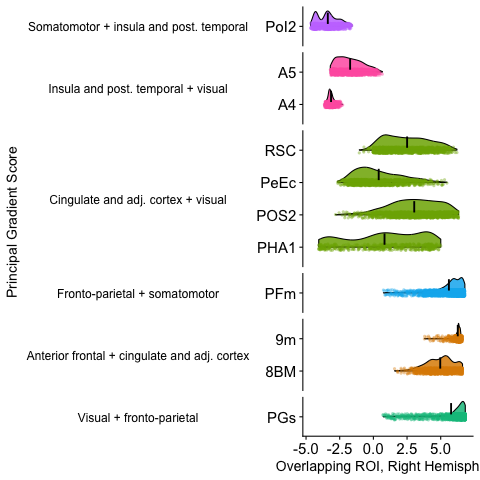

In [18]:
%%R -i merged_df 

# Vertex-wise distributions
merged_df %>%
    filter(module != "Unassigned" & overlapping == "Overlapping") %>%
    ungroup() %>%
    mutate(Glasser_RH_ROI = fct_reorder(Glasser_RH_ROI, PC1_value, .fun=mean)) %>%
    mutate(module_fct = fct_reorder(module, PC1_value, .fun=mean)) %>%
    rowwise() %>%
    mutate(region_label = gsub("R_", "", str_split(Glasser_RH_ROI, "_ROI")[[1]][1])) %>%
    ggplot(data=., mapping=aes(x=region_label, y=PC1_value, fill=module, color=module)) +
    # geom_violin(scale="width", position = position_nudge(x=0.25),
    #             linewidth=0.7, alpha=0.85) +
    geom_violinhalf(scale="width", color="black", position = position_dodge(width = 1), width=0.95, alpha=0.85)  +
    geom_point(position = position_jitter(width = 0.1, height=0),
                            size = 1.5, alpha=0.4, stroke=0) +
    stat_summary(color="black", fun="mean", geom="crossbar", width=0.35, linewidth=0.35, 
            show.legend=FALSE, position = position_nudge(x=0.25)) +
    xlab("Principal Gradient Score") +
    ylab("Overlapping ROI, Right Hemisphere") +
    coord_flip() +
    facet_grid(module_fct ~ ., space="free", scales="free_y", switch="both") +
    scale_fill_manual(values=c("Anterior frontal + cingulate and adj. cortex" = "#de8c00",
                              "Cingulate and adj. cortex + visual" = "#7cae00",
                              "Visual + fronto-parietal" = "#00c08b",
                              "Fronto-parietal + somatomotor" = "#00b4f0",
                              "Somatomotor + insula and post. temporal" = "#c77cff",
                              "Insula and post. temporal + visual" = "#ff64b0")) +
    scale_color_manual(values=c("Anterior frontal + cingulate and adj. cortex" = "#de8c00",
                              "Cingulate and adj. cortex + visual" = "#7cae00",
                              "Visual + fronto-parietal" = "#00c08b",
                              "Fronto-parietal + somatomotor" = "#00b4f0",
                              "Somatomotor + insula and post. temporal" = "#c77cff",
                              "Insula and post. temporal + visual" = "#ff64b0")) +
    theme(legend.position = "none",
          strip.placement='outside',
          strip.text.y.left = element_text(angle=0),
          axis.text = element_text(size=15),
          strip.background = element_blank())
# ggsave("../Plots/Overlapping_Modules_vs_Margulies_PC1_voxelwise.svg", width=7.5, height=6, units="in", dpi=300)